# Transcription Factor Analysis

We will explore and analyze gene expression data using the Seurat package in R.
Our goal is to gain insights into the transcription factors (TFs) that play a crucial role in gene regulation.
By understanding the TFs involved in gene regulation, we can gain insights into various biological processes, such as development, disease, and cellular responses.

We will identify key TFs, and analyze their expression patterns across clusters.

In [1]:
#### Load libraries ####
library(Seurat, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(org.Hs.eg.db, quietly = TRUE)  # for gene annotation
library(AnnotationDbi, quietly = TRUE)  # for gene annotation


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following object is masked from 'package:SeuratObject':

    intersect


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,

In [2]:
#### Load data ####
source(file.path("..", "preprocessing", "load_and_prepare_data.R"))

expression_matrix <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_umi_matrix.csv.gz"
)
metadata_path <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_cell_cluster_info.txt"
)

# load a Seurat object with standard Seurat preprocessing steps
seu_obj <- adult_human_heart(
  expression_matrix = expression_matrix,
  metadata_path = metadata_path
)


Attaching package: 'Matrix'


The following object is masked from 'package:S4Vectors':

    expand


New names:
• `` -> `...1`
Rows: 54750 Columns: 9995
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (1): ...1
dbl (9994): SC_92563_0_69, SC_92563_0_17, SC_92563_0_23, SC_92563_0_12, SC_9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 7495 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): ID, Condition, Group, Cluster_ID, CellType
dbl (2): nGene, nUMI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Normalizing layer: counts

Finding variable features for la

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9312
Number of edges: 331942

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9046
Number of communities: 16
Elapsed time: 0 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
13:08:57 UMAP embedding parameters a = 0.9922 b = 1.112

13:08:57 Read 9312 rows and found 10 numeric columns

13:08:57 Using Annoy for neighbor search, n_neighbors = 30

13:08:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:08:58 Writing NN index file to temp file C:\Users\dekel\AppData\Local\Temp\RtmpCURlIK\file9cb456ae3382

13:08:58 Searching Annoy index using 1 thread, search_k = 3000

13:09:00 Annoy recall = 100%

13:09:01 Commencing smooth kNN distance calibration using 1 thre

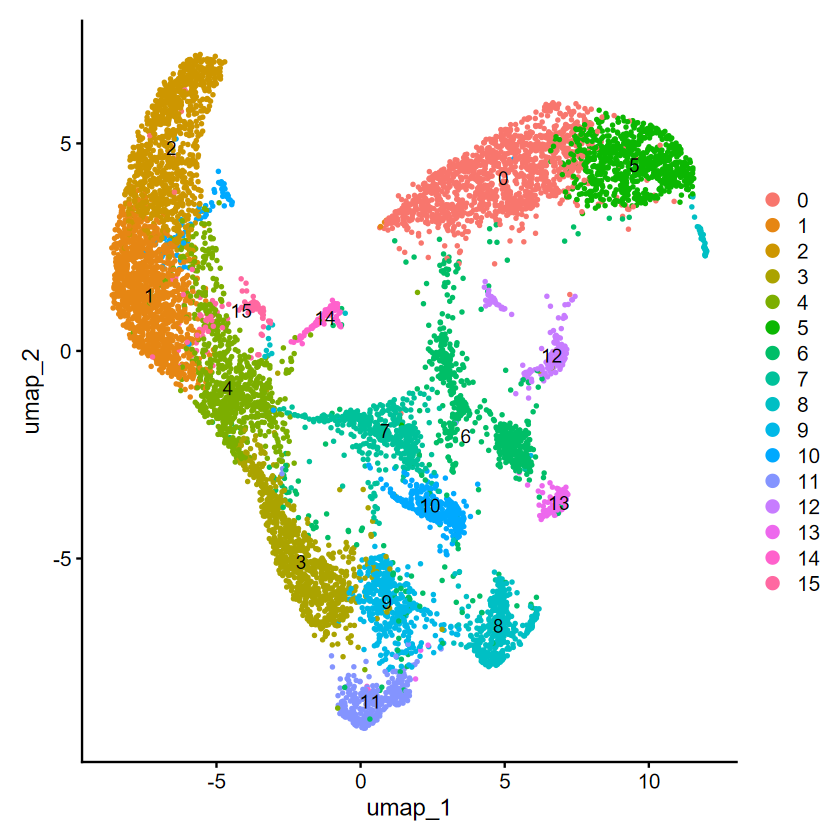

In [3]:
# Visualize clusters
DimPlot(seu_obj, reduction = "umap", label = TRUE, pt.size = 0.5)

Now that we loaded the data we can start observing TFs.
The simplest approach is to specify and plot specific TFs you want to observe for any changes.

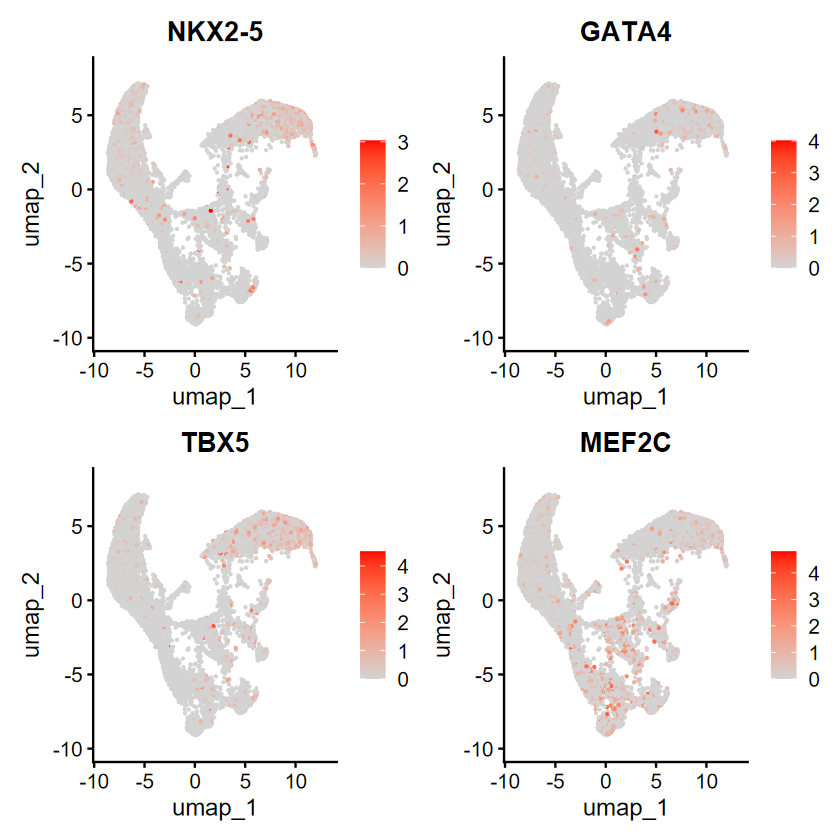

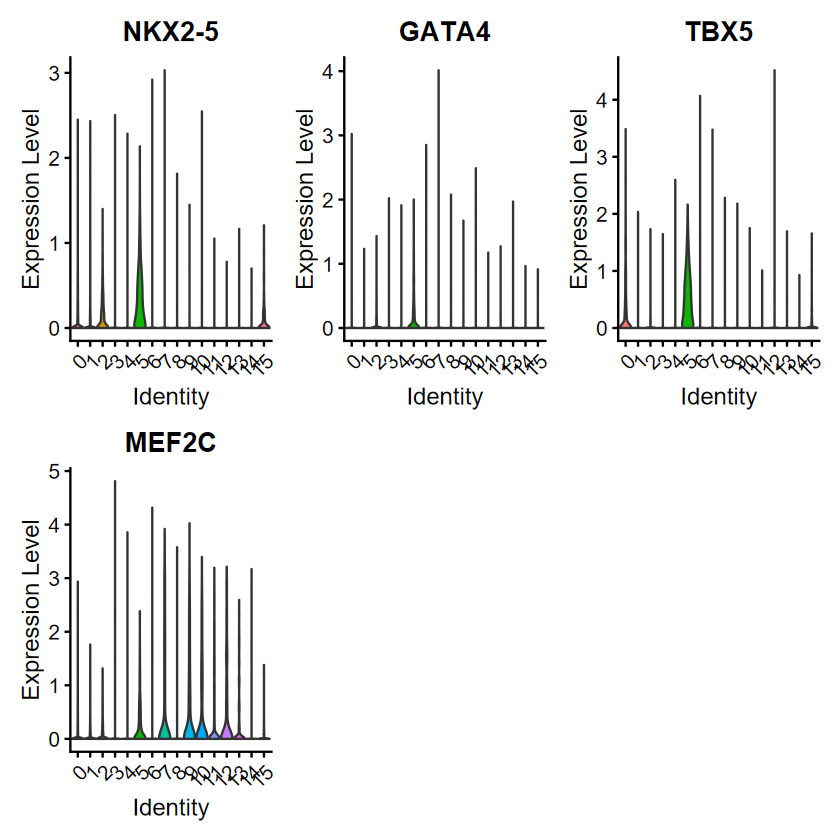

In [4]:
#### Feature plots of specific TFs ####
# Define key transcription factors
key_tfs <- c("NKX2-5", "GATA4", "TBX5", "MEF2C")

# Check if these genes are present in the dataset
key_tfs_present <- key_tfs[key_tfs %in% rownames(seu_obj)]

# Feature plots
FeaturePlot(seu_obj, key_tfs_present, cols = c("lightgrey", "red"))
# Violin plots
VlnPlot(seu_obj, key_tfs_present, pt.size = 0)


An unbiased approach can be to identify which TFs are unique to each cluster.

This might show which TFs are influencing clusters to be different from each other.

In [5]:
# Find markers specific to each cluster
heart_markers <- FindAllMarkers(seu_obj,
  only.pos = TRUE,
  min.pct = 0.25,
  logfc.threshold = 0.25
)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



In [8]:
# Now we have markers for each cluster,
# let's collect TFs so that we can narrow those markers to just TFs
library(biomaRt)
# Connect to the Ensembl BioMart database
mart <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

# genes associated with the GO term "DNA-binding transcription factor activity"
tf_data <- getBM(
  attributes = c("hgnc_symbol", "gene_biotype"),
  filters = "go",
  values = "GO:0003700",
  mart = mart
)

# Filter to include only protein-coding genes
tf_genes <- unique(tf_data$hgnc_symbol[
  tf_data$gene_biotype == "protein_coding"
])

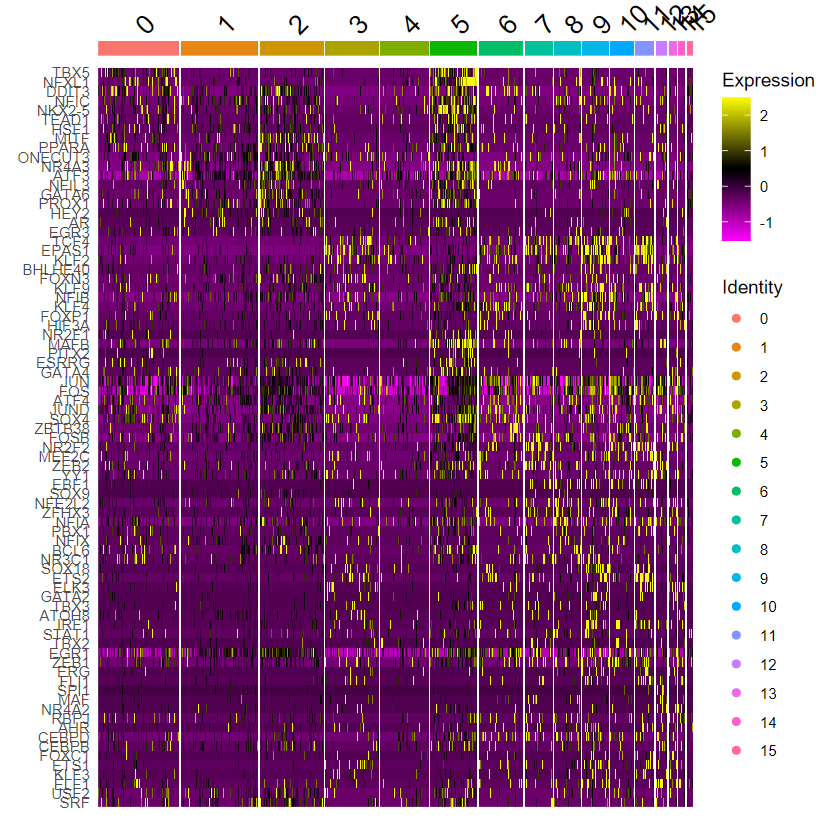

In [9]:
# Filter cluster markers to include only transcription factors
tf_markers <- heart_markers %>%
  filter(gene %in% tf_genes)

# Select top 10 transcription factors per cluster
top_tf_markers <- tf_markers %>%
  group_by(cluster) %>%
  top_n(n = 10, wt = avg_log2FC)

# Heatmap of top transcription factors unique to each cluster
DoHeatmap(seu_obj, features = top_tf_markers$gene)

Another great analysis is "Gene Regulatory Network" analysis.

This explores which TF's expression is correlated with the change in expression of other genes, highlighting possible causal effects.

In [ ]:
### gene regulatory network analysis with SCENIC and GENIE3 ###
# packages
# prepare seurat object for GENIE3...

# Let's do this with SCENIC also? GENIE3 is suitable for all organisms, so I'll stick with that